# Ch 4. 模型擬合、評估與超參數調校
## 4-4. 調校超參數
[4-4-1. 網格搜尋](#sec4_4_1)  
[4-4-2. 參數搜尋小技巧](#sec4_4_2)

## 4-5. 處理類別不平衡
[4-5. 處理類別不平衡](#sec4_5) 
***

<a id='sec4_4_1'></a>
## 4-4-1. 網格搜尋

In [1]:
import warnings
# 忽略警告訊息
warnings.filterwarnings("ignore")
import pandas as pd

df = pd.read_csv('Pokemon_894_13.csv')
# 增加一個欄位，標示在 Type1、Type2 中是否有 Water 屬性
type_ = 'Water'
lst1 = [1 if x == type_ else 0 for x in df.Type1]
lst2 = [1 if x == type_ else 0 for x in df.Type2]
df[type_] = [1 if lst1[i] or lst2[i] else 0 \
             for i in range(len(lst1))]
# 列出有無 Water 屬性的數量
print(df[type_].value_counts())
df.take([200,300,400])

0    754
1    140
Name: Water, dtype: int64


,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,Water
200,185,樹才怪,Rock,NaN,70,100,115,30,65,30,2,False,0
300,277,大王燕,Normal,Flying,60,85,60,50,50,125,3,False,0
400,365,帝牙海獅,Ice,Water,110,80,90,95,90,65,3,False,1


In [2]:
from sklearn.model_selection import train_test_split

X, y = df.loc[:, 'HP':'Speed'], df[type_]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, 
                     random_state=0)
print(X_train.shape)
print(X_test.shape)

(715, 6)
(179, 6)


In [3]:
from sklearn.linear_model import LogisticRegression

best_score = 0
# 以巢狀迴圈測試超參數組合
for p in ['l1', 'l2']:
    for c in [.001, .01, .1, 1, 10, 100]:
        # solver 改為 saga，同時應用到 L1, L2
        # max_iter 改為 1000，期待能盡量得到收斂結果
        logit = LogisticRegression(penalty=p, C=c, 
                                   solver='saga', max_iter=1000)
        logit.fit(X_train, y_train)
        score = logit.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_param = {'penalty':p, 'C':c}

print('Best score: %.3f' % best_score)
print('Best parameters:', best_param)

Best score: 0.866
Best parameters: {'penalty': 'l1', 'C': 0.001}


In [4]:
import numpy as np
from sklearn.model_selection import GridSearchCV

logit = LogisticRegression(solver='saga', max_iter=1000)
penalty = ['l1', 'l2']
# 產生 10 個 C 值
C = np.logspace(-4, 2, 10)
print(C)
hyper_param = dict(C=C, penalty=penalty)

grid_s = GridSearchCV(logit, hyper_param, cv=5, verbose=1)
grid_s.fit(X_train, y_train)
print('Best score (training):', grid_s.best_score_)
print('Best parameters (training):', grid_s.best_params_)
grid_s.score(X_test, y_test)

[1.00000000e-04 4.64158883e-04 2.15443469e-03 1.00000000e-02
 4.64158883e-02 2.15443469e-01 1.00000000e+00 4.64158883e+00
 2.15443469e+01 1.00000000e+02]
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score (training): 0.8377622377622378
Best parameters (training): {'C': 0.0001, 'penalty': 'l1'}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


0.8659217877094972

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline

# 設定隨機種子(目的是得到相同的執行結果以做驗證)
np.random.seed(0)
# 建立管線，先標準化再建立 SVC
pipe_svc = Pipeline([('std', StandardScaler()), 
                     ('svc', SVC())])
# 建立管線
pipe = Pipeline([('clf', RandomForestClassifier())])
# 產生候選模型與對應的超參數
param_range = np.logspace(-4, 2, 10)
param_grid = [{'clf': [LogisticRegression()], 
               'clf__penalty': ['l1', 'l2'], 
               'clf__C': param_range}, 
              {'clf': [RandomForestClassifier()], 
               'clf__n_estimators': [10, 100, 300, 500],
               'clf__max_depth': [3, 4, 5],
               'clf__max_features': [2, 3, 4]}, 
              {'clf': [pipe_svc], 
               'clf__svc__C': param_range, 
               'clf__svc__kernel': ['linear']},
              {'clf': [pipe_svc], 
               'clf__svc__C': param_range, 
               'clf__svc__gamma': param_range, 
               'clf__svc__kernel': ['rbf']}]

grid_s = GridSearchCV(estimator=pipe, 
                      param_grid=param_grid, scoring='accuracy', 
                      cv=5, verbose=1)
grid_s.fit(X_train, y_train)
print('Best score (training):', grid_s.best_score_)
print('Best parameters (training):', grid_s.best_params_)
grid_s.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 166 candidates, totalling 830 fits
Best score (training): 0.8391608391608392
Best parameters (training): {'clf': RandomForestClassifier(max_depth=4, max_features=3), 'clf__max_depth': 4, 'clf__max_features': 3, 'clf__n_estimators': 100}


[Parallel(n_jobs=1)]: Done 830 out of 830 | elapsed:  1.2min finished


0.8659217877094972

<a id='sec4_4_2'></a>
## 4-4-2. 參數搜尋小技巧

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, norm

logit = LogisticRegression(solver='saga', max_iter=1000, 
                           random_state=0)
# 產生均勻分布的樣本點
dist = dict(C=uniform(loc=0, scale=.01).rvs(100), 
            penalty=['l2', 'l1'])
# 隨機搜尋
clf = RandomizedSearchCV(logit, dist, random_state=0, 
                         verbose=1)
rand_s = clf.fit(X_train, y_train)
print(rand_s.best_params_)
rand_s.score(X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'penalty': 'l2', 'C': 0.002832609637559108}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


0.8659217877094972

In [7]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(Cs=100, cv=10, random_state=0)
logit.fit(X_train, y_train)
print('Best C:', logit.C_)
logit.score(X_test, y_test)

Best C: [0.0001]


0.8659217877094972

In [8]:
from sklearn.model_selection import cross_val_score

# 建立網格搜尋
grid_s = GridSearchCV(estimator=pipe, 
                      param_grid=param_grid, cv=2, 
                      scoring='accuracy', n_jobs=-1, 
                      verbose=1)
# 進行巢狀交叉驗證
scores = cross_val_score(grid_s, X_train, y_train, 
                         scoring='accuracy', cv=3)
print('CV accuracy (training): %.3f +/- %.3f' 
      %(np.mean(scores), np.std(scores)))
grid_s.fit(X_train, y_train)
print('Best parameters (training):', grid_s.best_params_)
grid_s.score(X_test, y_test)

Fitting 2 folds for each of 166 candidates, totalling 332 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 166 candidates, totalling 332 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 166 candidates, totalling 332 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 317 out of 332 | elapsed:    5.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CV accuracy (training): 0.838 +/- 0.002
Fitting 2 folds for each of 166 candidates, totalling 332 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 317 out of 332 | elapsed:    5.6s remaining:    0.2s


Best parameters (training): {'clf': RandomForestClassifier(max_depth=4, max_features=2, n_estimators=10), 'clf__max_depth': 4, 'clf__max_features': 2, 'clf__n_estimators': 10}


[Parallel(n_jobs=-1)]: Done 332 out of 332 | elapsed:    6.7s finished


0.8659217877094972

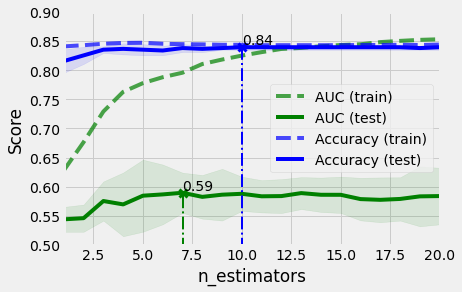

In [9]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import make_scorer, accuracy_score

# 套用兩個評分指標到網格搜尋
scoring = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score)}
gs = GridSearchCV(RandomForestClassifier(random_state=0),
                  param_grid={'n_estimators': range(1, 21), 
                              'max_depth': [4], 
                              'max_features': [4]},
                  scoring=scoring, refit='AUC', 
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
results = gs.cv_results_
# 取出決策樹數量作為 x 軸
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
# 設定 x, y 軸刻度範圍
ax = plt.gca()
ax.set_xlim(1, 20)
ax.set_ylim(0.5, 0.9)

for scorer, color in zip(sorted(scoring), ['g', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        # 取出不同評分指標的平均值與標準差
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, 
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
    # 取出 test 的最佳索引值與分數
    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]
    # 標示最大值
    ax.plot([X_axis[best_index], ] * 2, [0, best_score], lw=2,
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend()

In [10]:
type_ = 'Fire'
lst1 = [1 if x == type_ else 0 for x in df.Type1]
lst2 = [1 if x == type_ else 0 for x in df.Type2]
df[type_] = [1 if lst1[i] or lst2[i] else 0 \
             for i in range(len(lst1))]
# 列出有無 Fire 屬性的數量
print(df[type_].value_counts())
df.take([170,270,370])

0    822
1     72
Name: Fire, dtype: int64


,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,Water,Fire
170,156,火岩鼠,Fire,NaN,58,64,58,80,65,80,2,False,0,1
270,250,鳳王,Fire,Flying,106,130,90,110,154,90,2,True,0,1
370,338,太陽岩,Rock,Psychic,70,95,85,55,65,70,3,False,0,0


In [11]:
X, y = df.loc[:, 'HP':'Speed'], df[type_]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, 
                     random_state=0)
print(y_train.value_counts())
print(y_test.value_counts())

0    663
1     52
Name: Fire, dtype: int64
0    159
1     20
Name: Fire, dtype: int64


In [12]:
from sklearn.metrics import classification_report

pipe = Pipeline([('clf', RandomForestClassifier())])
param_range = np.logspace(-4, 2, 10)
param_grid = [{'clf': [LogisticRegression()], 
               'clf__penalty': ['l1', 'l2'], 
               'clf__C': param_range}, 
              {'clf': [RandomForestClassifier()], 
               'clf__n_estimators': [10, 20, 30, 50],
               'clf__max_depth': [3, 4, 5],
               'clf__max_features': [2, 3, 4]}]
# 評估指標為 accuracy
grid_s = GridSearchCV(estimator=pipe, cv=2, n_jobs=-1,
                      param_grid=param_grid, 
                      scoring='accuracy')
scores = cross_val_score(grid_s, X_train, y_train, 
                         scoring='accuracy', cv=3)
print('CV score (training): %.3f +/- %.3f' 
      %(np.mean(scores), np.std(scores)))
grid_s.fit(X_train, y_train)
print('Best parameters (training):', grid_s.best_params_)
y_pred = grid_s.predict(X_test)
print(classification_report(y_pred, y_test))

CV score (training): 0.926 +/- 0.002
Best parameters (training): {'clf': RandomForestClassifier(max_depth=5, max_features=2, n_estimators=10), 'clf__max_depth': 5, 'clf__max_features': 2, 'clf__n_estimators': 10}
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       179
           1       0.00      0.00      0.00         0

    accuracy                           0.89       179
   macro avg       0.50      0.44      0.47       179
weighted avg       1.00      0.89      0.94       179



In [13]:
from sklearn.metrics import classification_report

pipe = Pipeline([('clf', RandomForestClassifier())])
param_range = np.logspace(-4, 2, 10)
# 加入 class_weight 參數
param_grid = [{'clf': [LogisticRegression()], 
               'clf__penalty': ['l1', 'l2'], 
               'clf__C': param_range, 
               'clf__class_weight': ['balanced']}, 
              {'clf': [RandomForestClassifier()], 
               'clf__n_estimators': [10, 20, 30, 50],
               'clf__max_depth': [3, 4, 5],
               'clf__max_features': [2, 3, 4], 
               'clf__class_weight': ['balanced']}]

grid_s = GridSearchCV(estimator=pipe, cv=2, n_jobs=-1,
                      param_grid=param_grid, 
                      scoring='recall')
scores = cross_val_score(grid_s, X_train, y_train, 
                         scoring='recall', cv=3)
print('CV score (training): %.3f +/- %.3f' 
      %(np.mean(scores), np.std(scores)))
grid_s.fit(X_train, y_train)
print('Best parameters (training):', grid_s.best_params_)
y_pred = grid_s.predict(X_test)
print(classification_report(y_pred, y_test))

CV score (training): 0.709 +/- 0.088
Best parameters (training): {'clf': LogisticRegression(C=0.0001, class_weight='balanced'), 'clf__C': 0.0001, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.62      0.93      0.75       106
           1       0.65      0.18      0.28        73

    accuracy                           0.63       179
   macro avg       0.64      0.56      0.51       179
weighted avg       0.63      0.63      0.56       179



In [14]:
from sklearn.utils import resample

print(y_train.value_counts())
# 對類別 1 進行放回式取樣
size = y_train[y_train == 0].shape[0]
X_up, y_up = resample(X_train[y_train == 1], 
                      y_train[y_train == 1], 
                      replace=True, 
                      n_samples=size, 
                      random_state=0)
X_train_up = np.vstack((X_train[y_train==0], X_up))
y_train_up = np.hstack((y_train[y_train==0], y_up))
print('Class 0:', len(y_train_up) - y_train_up.sum())
print('Class 1:', y_train_up.sum())

0    663
1     52
Name: Fire, dtype: int64
Class 0: 663
Class 1: 663


In [15]:
# 邏輯斯迴歸擬合類別不平衡數據
logit = LogisticRegression().fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       179
           1       0.00      0.00      0.00         0

    accuracy                           0.89       179
   macro avg       0.50      0.44      0.47       179
weighted avg       1.00      0.89      0.94       179



In [16]:
# 邏輯斯迴歸加上 class_weight='balanced'
logit = LogisticRegression(class_weight='balanced')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.64      0.94      0.76       109
           1       0.65      0.19      0.29        70

    accuracy                           0.64       179
   macro avg       0.65      0.56      0.53       179
weighted avg       0.64      0.64      0.58       179



In [17]:
# 邏輯斯迴歸擬合經過上取樣的數據
logit = LogisticRegression()
logit.fit(X_train_up, y_train_up)
y_pred = logit.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.94      0.77       112
           1       0.65      0.19      0.30        67

    accuracy                           0.66       179
   macro avg       0.66      0.57      0.54       179
weighted avg       0.66      0.66      0.60       179

